Daily Temperature

In [17]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [18]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [19]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2024-02-16 07:46:47--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2024-02-16 07:46:47 (3.88 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



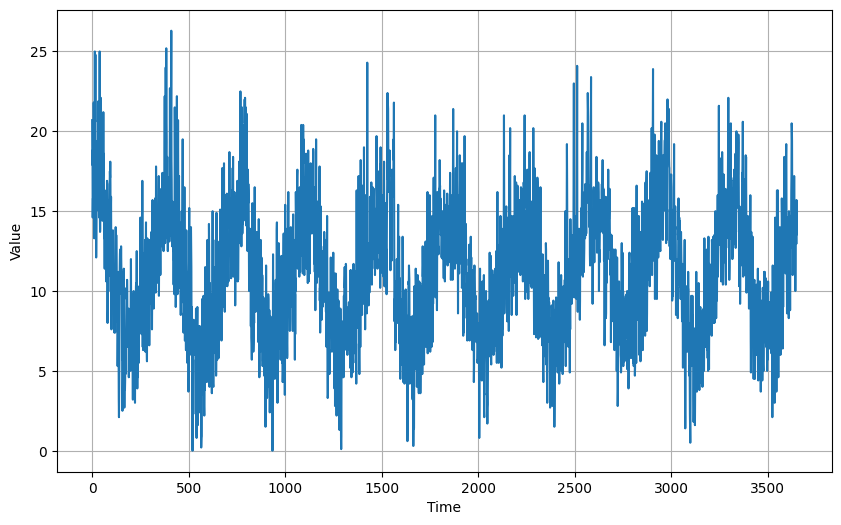

In [20]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [21]:
series

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))
print(series)
series = series.flatten()
series

[[0.78707224]
 [0.68060837]
 [0.7148289 ]
 ...
 [0.51330798]
 [0.59695817]
 [0.49429658]]


array([0.78707224, 0.68060837, 0.7148289 , ..., 0.51330798, 0.59695817,
       0.49429658])

In [23]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1)) #chủ yếu là chia batch
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:])) # lấy vị trí từ đầu trừ phần tử cuối làm feature và lấy chuỗi phần tử cuối làm nhãn
    return ds.batch(batch_size).prefetch(1)

In [25]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional


Đầu vào 60 giá trị và đầu ra 60 gái trị (1-60) -> (2, 61)

In [27]:

tf.random.set_seed(0)
np.random.seed(0)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=64, shuffle_buffer=shuffle_buffer_size)


In [28]:
x = list(train_set.as_numpy_iterator())

In [29]:
x[0][0]

array([[[0.86311787],
        [0.6539924 ],
        [0.51330798],
        ...,
        [0.45627376],
        [0.47148289],
        [0.4904943 ]],

       [[0.29657795],
        [0.23954373],
        [0.23954373],
        ...,
        [0.60836502],
        [0.60076046],
        [0.46007605]],

       [[0.25855513],
        [0.21673004],
        [0.23193916],
        ...,
        [0.2851711 ],
        [0.42585551],
        [0.55513308]],

       ...,

       [[0.58935361],
        [0.39163498],
        [0.39923954],
        ...,
        [0.40684411],
        [0.47908745],
        [0.52471483]],

       [[0.25855513],
        [0.22053232],
        [0.22813688],
        ...,
        [0.49429658],
        [0.50190114],
        [0.45627376]],

       [[0.121673  ],
        [0.21673004],
        [0.29277567],
        ...,
        [0.40684411],
        [0.29657795],
        [0.36501901]]])

In [30]:
x[0][1].shape

(64, 60, 1)

In [31]:

tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
                    LSTM(64, return_sequences=True), # bản chất là return ra từng giá trị h0 h1 để output có đủ 60 đầu ra
                    Dense(32, activation='relu'),
                    Dense(1)
])
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100)

Epoch 1/100
39/39 [==============================] - 10s 39ms/step - loss: 0.0210 - mae: 0.1541
Epoch 2/100
39/39 [==============================] - 2s 39ms/step - loss: 0.0073 - mae: 0.0915
Epoch 3/100
39/39 [==============================] - 2s 57ms/step - loss: 0.0064 - mae: 0.0867
Epoch 4/100
39/39 [==============================] - 2s 43ms/step - loss: 0.0059 - mae: 0.0834
Epoch 5/100
39/39 [==============================] - 2s 38ms/step - loss: 0.0055 - mae: 0.0811
Epoch 6/100
39/39 [==============================] - 2s 39ms/step - loss: 0.0052 - mae: 0.0797
Epoch 7/100
39/39 [==============================] - 2s 39ms/step - loss: 0.0051 - mae: 0.0786
Epoch 8/100
39/39 [==============================] - 2s 38ms/step - loss: 0.0049 - mae: 0.0776
Epoch 9/100
39/39 [==============================] - 3s 61ms/step - loss: 0.0048 - mae: 0.0770
Epoch 10/100
39/39 [==============================] - 2s 38ms/step - loss: 0.0047 - mae: 0.0760
Epoch 11/100
39/39 [============================

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, None, 64)          16896     
                                                                 
 dense_2 (Dense)             (None, None, 32)          2080      
                                                                 
 dense_3 (Dense)             (None, None, 1)           33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Sunspot

In [33]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [34]:
from sklearn.preprocessing import MinMaxScaler


In [35]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [39]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/adib0073/TimeSeries-Using-TensorFlow/main/Data/Sunspots.csv \
    -O /tmp/sunspots.csv

--2024-02-16 07:51:50--  https://raw.githubusercontent.com/adib0073/TimeSeries-Using-TensorFlow/main/Data/Sunspots.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/plain]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.02s   

2024-02-16 07:51:50 (3.83 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



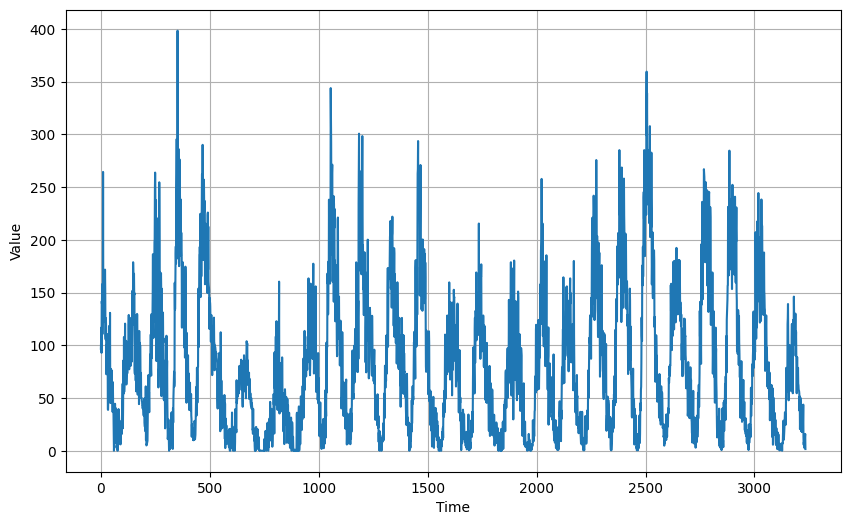

In [40]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [41]:
series

array([ 96.7, 104.3, 116.7, ...,  13.2,  15.9,   1.6])

In [42]:
scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))
print(series)

[[0.24284279]
 [0.26192868]
 [0.29306881]
 ...
 [0.03314917]
 [0.03992968]
 [0.00401808]]


In [43]:
series = series.flatten()

In [44]:
series

array([0.24284279, 0.26192868, 0.29306881, ..., 0.03314917, 0.03992968,
       0.00401808])

In [45]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [46]:
len(x_train)

3000

In [47]:
len(x_valid)

235

In [48]:
def load_image_test(image, label):
  scaled_image = image / 255.0
  return scaled_image, label

In [49]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds


In [50]:
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Bidirectional
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint

In [52]:
checkpoint = ModelCheckpoint(filepath='model.h5', monitor='mae', verbose=0, save_best_only=True)

In [53]:
clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)

In [54]:
# (64, 60, 7)

In [55]:
list(train_set.take(1))

[(<tf.Tensor: shape=(64, 60, 1), dtype=float64, numpy=
  array([[[0.18407835],
          [0.14239076],
          [0.09718734],
          ...,
          [0.5642893 ],
          [0.41511803],
          [0.53566047]],
  
         [[0.20165746],
          [0.20015068],
          [0.19663486],
          ...,
          [0.10045203],
          [0.11300854],
          [0.10472125]],
  
         [[0.10748368],
          [0.10045203],
          [0.10873933],
          ...,
          [0.62280261],
          [0.66223004],
          [0.61978905]],
  
         ...,
  
         [[0.09969864],
          [0.04193872],
          [0.05022602],
          ...,
          [0.04721246],
          [0.00803616],
          [0.00301356]],
  
         [[0.06253139],
          [0.0492215 ],
          [0.01155198],
          ...,
          [0.44801607],
          [0.54269211],
          [0.60647916]],
  
         [[0.01682572],
          [0.01808137],
          [0.0208438 ],
          ...,
          [0.63912607],
  

In [60]:
model = Sequential([
      LSTM(64, return_sequences=True, input_shape=[None, 1]),
      Dense(32, activation='relu'),
      Dense(7)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

Epoch 1/100
46/46 [==============================] - 4s 42ms/step - loss: 0.0130 - mae: 0.1145
Epoch 2/100
46/46 [==============================] - 2s 41ms/step - loss: 0.0037 - mae: 0.0619
Epoch 3/100
40/46 [=========================>....] - ETA: 0s - loss: 0.0029 - mae: 0.0543

KeyboardInterrupt: 

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          18432     
                                                                 
 dense (Dense)               (None, None, 32)          2080      
                                                                 
 dense_1 (Dense)             (None, None, 7)           231       
                                                                 
Total params: 20743 (81.03 KB)
Trainable params: 20743 (81.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
model = Sequential([
      LSTM(64, return_sequences=True),
      LSTM(64, return_sequences=True),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

Epoch 1/100
46/46 [==============================] - 9s 83ms/step - loss: 0.0101 - mae: 0.1027


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
46/46 [==============================] - 4s 83ms/step - loss: 0.0036 - mae: 0.0603
Epoch 3/100
46/46 [==============================] - 4s 78ms/step - loss: 0.0028 - mae: 0.0534
Epoch 4/100
46/46 [==============================] - 5s 100ms/step - loss: 0.0025 - mae: 0.0511
Epoch 5/100
46/46 [==============================] - 4s 87ms/step - loss: 0.0024 - mae: 0.0499
Epoch 6/100
46/46 [==============================] - 5s 91ms/step - loss: 0.0023 - mae: 0.0488
Epoch 7/100
46/46 [==============================] - 5s 100ms/step - loss: 0.0022 - mae: 0.0475
Epoch 8/100
46/46 [==============================] - 4s 79ms/step - loss: 0.0021 - mae: 0.0467
Epoch 9/100
46/46 [==============================] - 4s 80ms/step - loss: 0.0021 - mae: 0.0462
Epoch 10/100
46/46 [==============================] - 4s 85ms/step - loss: 0.0020 - mae: 0.0456
Epoch 11/100
46/46 [==============================] - 4s 79ms/step - loss: 0.0020 - mae: 0.0453
Epoch 12/100
46/46 [==========================

KeyboardInterrupt: 

In [61]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

101/101 [==============================] - 97s 9ms/step


0.03980696

In [ ]:
model = Sequential([
      Bidirectional(LSTM(64, return_sequences=True)),
      Bidirectional(LSTM(64, return_sequences=True)),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
                    Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=[None, 1]),
                    LSTM(64, return_sequences=True),
                    LSTM(64, return_sequences=True),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

Conv1D

In [ ]:
clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
      Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=[None, 1]),
      LSTM(64, return_sequences=True),
      LSTM(64, return_sequences=True),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
model.summary()

Forcast

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1 , drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(16, 8))
    plot_series(time_valid, x_valid)
    plot_series(time_valid, rnn_forecast)
    labels = ['Real', 'Predicted']
    plt.legend(labels)
    plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [78]:
data = [1,2,3]

In [79]:
data = np.array(data)

In [80]:
data.shape

(3,)

In [81]:
data = tf.expand_dims(data, axis=-1)
print(data.shape)
dataset = tf.data.Dataset.from_tensor_slices(data)
for element in dataset:
  print(element.shape)

(3, 1)
(1,)
(1,)
(1,)
